## IMPORTS AND SET UP

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

# 1. Define Variables
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# 2. Define Paths (Relative to your .ipynb)
base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# 3. Setup Data Generators
# Augmentation for Training (To fix dataset size issues)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for Validation/Test (Just rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Load Images
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nLoading Validation Data:")
validation_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Check classes
print(f"\nClasses found: {train_generator.class_indices}")

Loading Training Data:
Found 718 images belonging to 2 classes.

Loading Validation Data:
Found 208 images belonging to 2 classes.

Classes found: {'icecream': 0, 'pizza': 1}


In [42]:
# 1. Build the Model
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The Brain
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    # CHANGED: Dropout from 0.5 to 0.3
    # This relaxes the "strictness" so the Training line can pull up slightly
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 2. Compile with a Custom Optimizer
# CHANGED: We manually set the learning rate to be lower (0.0005)
# This prevents the "jittery" spikes in your graph.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 28, 28, 128)     

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Gentle Brakes
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3,       # Wait longer before reducing speed
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

# 2. Relaxed Safety Net
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,       # Allow it to run longer to settle the lines
    restore_best_weights=True
)

# 3. Train
print("Starting training for the 'Smooth Graph' look...")
history = model.fit(
    train_generator,
    epochs=30,  # More epochs because we are learning slower
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)

Starting training for the 'Smooth Graph' look...
Epoch 1/30
23/23 [==============================] - 60s 3s/step - loss: 1.1482 - accuracy: 0.6574 - val_loss: 0.6697 - val_accuracy: 0.5817 - lr: 5.0000e-04
Epoch 2/30
23/23 [==============================] - 64s 3s/step - loss: 0.5137 - accuracy: 0.7354 - val_loss: 0.3875 - val_accuracy: 0.8269 - lr: 5.0000e-04
Epoch 3/30
23/23 [==============================] - 43s 2s/step - loss: 0.4011 - accuracy: 0.8134 - val_loss: 0.3403 - val_accuracy: 0.8317 - lr: 5.0000e-04
Epoch 4/30
23/23 [==============================] - 20s 888ms/step - loss: 0.3621 - accuracy: 0.8370 - val_loss: 0.3385 - val_accuracy: 0.8606 - lr: 5.0000e-04
Epoch 5/30
23/23 [==============================] - 44s 2s/step - loss: 0.3931 - accuracy: 0.8315 - val_loss: 0.3037 - val_accuracy: 0.8990 - lr: 5.0000e-04
Epoch 6/30
23/23 [==============================] - 63s 3s/step - loss: 0.3323 - accuracy: 0.8565 - val_loss: 0.3141 - val_accuracy: 0.8558 - lr: 5.0000e-04
Epoch 

Graph successfully saved at: c:\Users\evang\Downloads\Pen_vs_Pencil_Project\PIZZA VS ICE CREAM\accuracy_graph_2.png


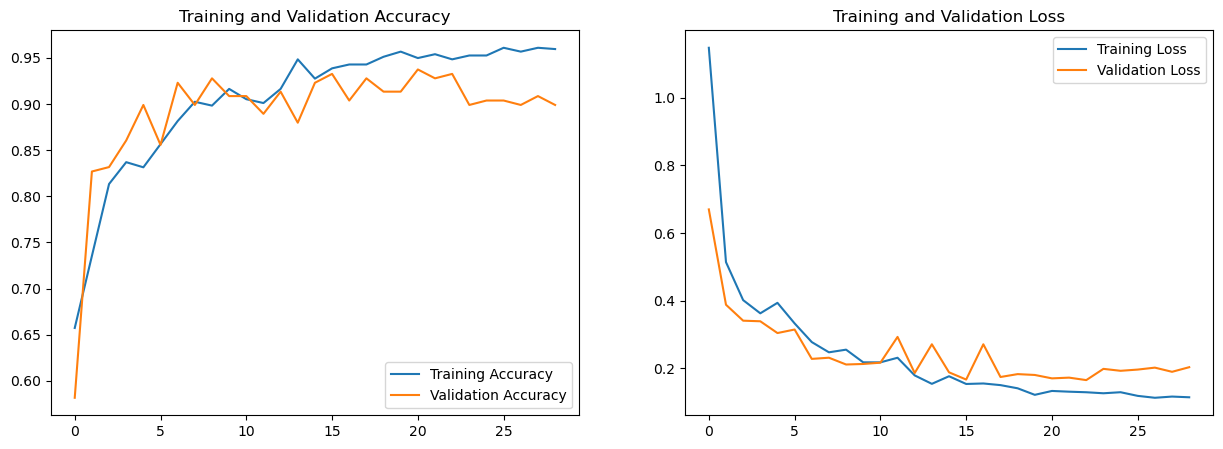

In [ ]:
import matplotlib.pyplot as plt
import os

# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Accuracy Chart
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Chart
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# --- SAVE LOGIC --
# This ensures it saves in the same folder as your model.ipynb
filename = "accuracy_graph_2.png"
save_path = os.path.join(os.getcwd(), filename)

plt.savefig(save_path) 
print(f"Graph successfully saved at: {save_path}")
# -----------------

plt.show()

In [48]:
import matplotlib.pyplot as plt
import os

def save_accuracy_plot(history, filename="accuracy_graph_2.png"):
    # Specify the folder name
    folder = "PIZZA VS ICE CREAM"
    
    # Create the full path (e.g., 'PIZZA VS ICE CREAM/accuracy_graph_2.png')
    # Using os.path.join is best practice for cross-platform compatibility
    save_path = os.path.join(folder, filename)
    
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save to the specific folder path
    plt.savefig(save_path) 
    plt.show()
    plt.close() # Clean up memory

In [46]:
# Load Test Data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Evaluate
print("\nRunning Final Test...")
results = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {results[1]*100:.2f}%")

Found 105 images belonging to 2 classes.

Running Final Test...
4/4 [==============================] - 2s 463ms/step - loss: 0.0590 - accuracy: 0.9905

Final Test Accuracy: 99.05%


Found 4 images. Creating grid...



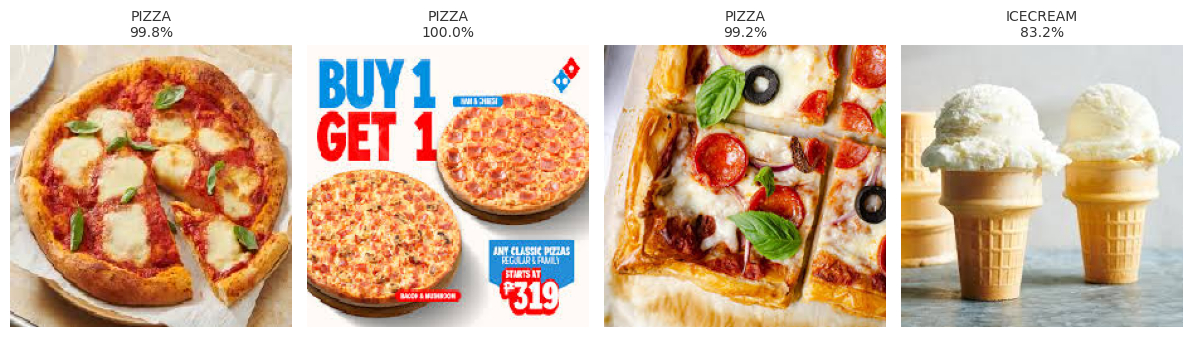

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import math

# 1. Define path
final_folder_path = './dataset/final'

# 2. Get Labels automatically
labels = {value: key for key, value in train_generator.class_indices.items()}

# 3. Get all valid image files first
files = [f for f in os.listdir(final_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
num_images = len(files)

if num_images == 0:
    print("No images found in the folder!")
else:
    print(f"Found {num_images} images. Creating grid...\n")

    # 4. Calculate Grid Size (5 images per row)
    cols = 5
    rows = math.ceil(num_images / cols)

    # Create the big canvas (Width=15, Height scales with rows)
    plt.figure(figsize=(15, 3.5 * rows))

    for i, filename in enumerate(files):
        # --- A. Load & Predict ---
        img_path = os.path.join(final_folder_path, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array, verbose=0)
        score = prediction[0][0]
        
        if score > 0.5:
            label = labels[1]
            confidence = score * 100
        else:
            label = labels[0]
            confidence = (1 - score) * 100

        # --- B. Plot in the Grid ---
        # "i + 1" is the slot number (1, 2, 3, 4, 5...)
        plt.subplot(rows, cols, i + 1) 
        plt.imshow(img)
        plt.axis('off') # Clean look
        
        # Title with color logic (Optional: Blue for high confidence)
        plt.title(f"{label.upper()}\n{confidence:.1f}%", fontsize=10, color='#333333')

    plt.tight_layout()
    plt.show()